Presence of the following datasets is required.<br>
`./datasets/taskmaster`

In [1]:
# Control whether the network should run on GPU or CPU
USE_CPU=False

In [2]:
import os
import tensorflow as tf

# CPU or GPU
if USE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

    # GPU presence check
    if tf.test.gpu_device_name():
        print('GPU found')
    else:
        print("No GPU found")

In [3]:
!nvidia-smi

Sat Jul 18 18:41:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   35C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
# based on: https://stackabuse.com/text-classification-with-bert-tokenizer-and-tf-2-0-in-python/

In [5]:
import tensorflow_hub as hub

from tensorflow.keras import layers
import bert

import re
import random
import pandas as pd

In [6]:
def text_tokens(text):
    # transforming to lowercase
    text = text.lower()
    # replacing whitespace characters with spaces
    text = re.sub("\\s", " ", text)
    # removing everything that is not a letter
    text = re.sub("[^a-zA-Z ']", "", text)
    
    # splitting string into array based on spaces
    tokens = text.split(' ')
    
    # removing empty strings from the tokens array
    tokens = list(filter(('').__ne__, tokens))
    
    return tokens

In [7]:
# extracting utterances from the taskmaster dataset
def tm_getter(path):
    SPEAKER=False
    
    collection = []
    f = open(path, 'r')
    for x in f:
        if '"speaker":' in x:
            SPEAKER=True
        else:
            if SPEAKER == True:
                SPEAKER=False
                if '"text":' in x:
                    collection.append(text_tokens(x.lstrip()[len('"text": '):]))
            
    return collection

In [8]:
tm_data = (
    tm_getter("datasets/taskmaster/flights.json") +\
    tm_getter("datasets/taskmaster/food-ordering.json") +\
    tm_getter("datasets/taskmaster/hotels.json") +\
    tm_getter("datasets/taskmaster/movies.json") +\
    tm_getter("datasets/taskmaster/music.json") +\
    tm_getter("datasets/taskmaster/restaurant-search.json") +\
    tm_getter("datasets/taskmaster/sports.json")
)

In [9]:
print(tm_data[0])

['hello', "i'd", 'like', 'to', 'find', 'a', 'round', 'trip', 'commercial', 'airline', 'flight', 'from', 'san', 'francisco', 'to', 'denver']


In [10]:
def split_data(data):
    X = []
    Y = []
    s = []
    for i in range(len(data)):
        if i < (3*len(data))/4:
            # for splitting, only sentences longer then 4 words are considered
            if len(data[i]) > 4:
                # too long sentences are skipped
                if (len(data[i]) <= 50):
                    # first half of the dataset is made out of interrupted conversation turns 
                    # picking random point for splitting the conversation turn
                    l = random.randrange(1, len(data[i]) - 3)
                    # splitting data
                    X.append(' '.join(data[i][:l]))
                    # adding 0 to the target list -> 0 -- interrupted turn 
                    Y.append(0)
                    s.append(' '.join(data[i]))

            else:
                X.append(' '.join(data[i]))
                Y.append(1)
                s.append(' '.join(data[i]))
        else:
            X.append(' '.join(data[i]))
            Y.append(1)
            s.append(' '.join(data[i]))
    
    return pd.DataFrame(data={'original text' : s, 'text' : X, 'label' : Y})

In [11]:
# creating dataset with artificially ended utterances and naturally ended utterances 
pd_tm = split_data(tm_data)

In [12]:
print('label 1:', len(pd_tm[pd_tm.label == 1]), 'label 0:', len(pd_tm[pd_tm.label == 0]))

label 1: 179105 label 0: 161610


In [13]:
pd_tm.head()

,original text,text,label
0,hello i'd like to find a round trip commercial...,hello i'd like to find a round trip commercial...,0
1,hello how can i help you,hello,0
2,san francisco to denver got it,san francisco,0
3,you're really on top of things i like that,you're really on top,0
4,so what days are you looking to fly,so what days are,0


### BERT tokenizer

In [14]:
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [15]:
print(tokenizer.tokenize(pd_tm.text[0]))

['hello', 'i', "'", 'd', 'like', 'to', 'find', 'a', 'round', 'trip', 'commercial', 'airline', 'flight']


In [16]:
tokenizer.convert_tokens_to_ids(tokenizer.tokenize(pd_tm.text[0]))

[7592, 1045, 1005, 1040, 2066, 2000, 2424, 1037, 2461, 4440, 3293, 8582, 3462]

In [17]:
def tokenize_utterances(text_utterances):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text_utterances))

In [18]:
tokenized_utterances = [tokenize_utterances(utterance) for utterance in pd_tm.text]

In [19]:
utterances_with_len = [[utterance, pd_tm.label[i], len(utterance)]
                 for i, utterance in enumerate(tokenized_utterances)]

In [20]:
random.shuffle(utterances_with_len)

In [21]:
utterances_with_len.sort(key=lambda x: x[2])

In [22]:
fixed = []

for x in utterances_with_len:
    if x[2] > 3:
        fixed.append(x)
        
utterances_with_len = fixed

In [23]:
sorted_utterances_labels = [(utterance_lab[0], utterance_lab[1]) for utterance_lab in utterances_with_len]

In [24]:
processed_dataset =\
    tf.data.Dataset.from_generator(lambda: sorted_utterances_labels, output_types=(tf.int32, tf.int32))

In [25]:
BATCH_SIZE = 16
batched_dataset = processed_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))

In [26]:
next(iter(batched_dataset))

(<tf.Tensor: shape=(16, 4), dtype=int32, numpy=
 array([[ 2182,  2003,  2115,  2299],
        [ 1996,  8859,  5302, 11451],
        [ 2907,  2006,  1037,  2117],
        [ 7632,  3353,  1045,  2342],
        [ 1045,  1005,  1040,  2066],
        [ 2625,  2084,  1037,  2711],
        [ 3100,  1043, 12541,  2891],
        [ 9061,  2127,  2279,  2051],
        [ 1050,  2094,  3203,  4743],
        [ 5834,  2006,  4026,  2009],
        [ 1045,  2572,  3241,  2065],
        [ 2061,  3260,  5263,  2003],
        [ 1045,  2031,  2312,  2980],
        [ 2008,  1005,  1055,  2035],
        [ 2031,  1037,  2307,  2154],
        [ 1037,  2103,  1999,  2885]], dtype=int32)>,
 <tf.Tensor: shape=(16,), dtype=int32, numpy=array([1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1], dtype=int32)>)

In [27]:
import math

TOTAL_BATCHES = math.ceil(len(sorted_utterances_labels) / BATCH_SIZE)
TEST_BATCHES = TOTAL_BATCHES // 10
batched_dataset.shuffle(TOTAL_BATCHES)
test_data = batched_dataset.take(TEST_BATCHES)
train_data = batched_dataset.skip(TEST_BATCHES)

In [28]:
class TEXT_MODEL(tf.keras.Model):
    
    def __init__(self,
                 vocabulary_size,
                 embedding_dimensions=128,
                 cnn_filters=50,
                 dnn_units=512,
                 model_output_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="text_model"):
        super(TEXT_MODEL, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocabulary_size,
                                          embedding_dimensions)
        self.cnn_layer1 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer2 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer3 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer4 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer5 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer6 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=4,
                                        padding="valid",
                                        activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units=dnn_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)

        self.last_dense = layers.Dense(units=1, activation="sigmoid")
    
    def call(self, inputs, training):
        l = self.embedding(inputs)
        l_1 = self.cnn_layer1(l) 
        l_1 = self.pool(l_1) 
        l_2 = self.cnn_layer2(l) 
        l_2 = self.pool(l_2)
        l_3 = self.cnn_layer3(l)
        l_3 = self.pool(l_3)
        l_4 = self.cnn_layer4(l)
        l_4 = self.pool(l_4)
        l_5 = self.cnn_layer5(l)
        l_5 = self.pool(l_5)
        l_6 = self.cnn_layer6(l)
        l_6 = self.pool(l_6)
        
        concatenated = tf.concat([l_1, l_2, l_3, l_4, l_5, l_6], axis=-1) # (batch_size, 3 * cnn_filters)
        concatenated = self.dense_1(concatenated)
        concatenated = self.dropout(concatenated, training)
        model_output = self.last_dense(concatenated)
        
        return model_output

In [29]:
VOCAB_LENGTH = len(tokenizer.vocab)
EMB_DIM = 200
CNN_FILTERS = 100
DNN_UNITS = 256
OUTPUT_CLASSES = 2

DROPOUT_RATE = 0.2

NB_EPOCHS = 10

In [30]:
text_model = TEXT_MODEL(vocabulary_size=VOCAB_LENGTH,
                        embedding_dimensions=EMB_DIM,
                        cnn_filters=CNN_FILTERS,
                        dnn_units=DNN_UNITS,
                        model_output_classes=OUTPUT_CLASSES,
                        dropout_rate=DROPOUT_RATE)

In [31]:
text_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [32]:
LOAD_SAVED=True

In [33]:
if LOAD_SAVED:
    text_model.load_weights('./saves/save_tokenizer2')
else:
    text_model.fit(train_data, epochs=NB_EPOCHS)
    text_model.save_weights('./saves/save_tokenizer2')

In [34]:
# GPU: 56 seconds, CPU: 55 seconds
results = text_model.evaluate(train_data)
print(results)

   8899/Unknown - 54s 6ms/step - loss: 0.3519 - accuracy: 0.9148[0.3519458684755953, 0.9147844]


In [35]:
results = text_model.evaluate(test_data)
print(results)

    988/Unknown - 5s 5ms/step - loss: 0.7160 - accuracy: 0.8448[0.7159622897583, 0.8448254]


---

In [36]:
# PREDICTION TIME MEASUREMENT (based on 100 predictions, mainly for CPU/GPU speed comparison)

import time
import numpy as np

# ------------
sentence = 'Book three seats for tonight please'

cntr = 0
for i in range(100):
    start = time.time()
    text_model.predict([tokenize_utterances(sentence)])
    end = time.time()
    
    cntr += np.around(end - start, 8)
# ------------


print(np.around(cntr/100, 8), 'seconds')

0.02877099 seconds


In [60]:
# network testing

N=10

ones = 0
zeros = 0

for text, label in zip(pd_tm.text, pd_tm.label):
    u = tokenize_utterances(text)
    
    if (label == 0) and (zeros < N/2):
        if len(u) > 3:
            zeros += 1
            print(np.around(text_model.predict([u])[0][0],2), '\t', label, '\t', text)
    if (label == 1) and (ones < N/2):
        if len(u) > 3:
            ones += 1
            print(np.around(text_model.predict([u])[0][0],2), '\t', label, '\t', text)
    
    if (zeros + ones) == N:
        break

0.0 	 0 	 hello i'd like to find a round trip commercial airline flight
1.0 	 0 	 you're really on top
0.02 	 0 	 so what days are
0.0 	 0 	 so i would like to fly out sometime tonight and fly
0.97 	 0 	 that's right
0.95 	 1 	 that sounds very good
0.99 	 1 	 how does am work
1.0 	 1 	 okay it's possible
1.0 	 1 	 sounds good to me
1.0 	 1 	 that should be everything


### Accuracy testing based on sentence length (number of words) 

In [38]:
# get a batch of sentences based on length (number of words) = i parameter
def get_batch(i):
    tokenized_utterances = [tokenize_utterances(utterance) for utterance in pd_tm.text]

    utterances_with_len = [[utterance, pd_tm.label[i], len(utterance)]
                     for i, utterance in enumerate(tokenized_utterances)]

    utterances_with_len.sort(key=lambda x: x[2])

    fixed = []
    for x in utterances_with_len: 
        if x[2] == i: fixed.append(x)

    utterances_with_len = fixed

    sorted_utterances_labels = [(utterance_lab[0], utterance_lab[1]) for utterance_lab in utterances_with_len]

    processed_dataset =\
        tf.data.Dataset.from_generator(lambda: sorted_utterances_labels, output_types=(tf.int32, tf.int32))

    batched_dataset = processed_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))

    batched_dataset.shuffle(TOTAL_BATCHES)
    return batched_dataset.take(TEST_BATCHES)

In [39]:
ev_data = []

for sentence in list(pd_tm.text):
    ev_data.append(sentence.split(' '))

In [40]:
data_clean = list(pd_tm['text'])
Y = pd_tm['label']

In [41]:
res_Y = [[] for i in range(61)]
res_clean = [[] for i in range(61)]
results = []

for i in range(len(ev_data)):
    if len(ev_data[i]) < 60:
        res_Y[len(ev_data[i])].append(Y[i])
        res_clean[len(ev_data[i])].append(" ".join(ev_data[i]))

zeros = []
ones = []
        
for i in range(3,61):
    print('\n',i)
    print('Sentence len:', i, ', number of sentences:', len(res_clean[i]))
    
    zeros_ = len(np.array(res_Y[i])[np.array(res_Y[i]) == 0])
    ones_ = len(np.array(res_Y[i])[np.array(res_Y[i]) == 1])
    
    print('0:', zeros_, '1:', ones_)
    
    zeros.append(zeros_)
    ones.append(ones_)
    
    
    if zeros_ + ones_ > 0:
        results.append(text_model.evaluate(get_batch(i)))
    else:
        results.append([0,0])


 3
Sentence len: 3 , number of sentences: 47197
0: 20345 1: 26852
    988/Unknown - 5s 5ms/step - loss: 0.6170 - accuracy: 0.8344
 4
Sentence len: 4 , number of sentences: 37025
0: 13653 1: 23372
    988/Unknown - 5s 5ms/step - loss: 0.7615 - accuracy: 0.8370
 5
Sentence len: 5 , number of sentences: 18958
0: 9875 1: 9083
    988/Unknown - 5s 5ms/step - loss: 0.6291 - accuracy: 0.8346
 6
Sentence len: 6 , number of sentences: 16508
0: 7155 1: 9353
    988/Unknown - 5s 5ms/step - loss: 0.4270 - accuracy: 0.8827- 5s 5ms/step - loss: 0.4820 - accuracy: 0.8 - 5s 5ms/step - loss: 0.4803 - 
 7
Sentence len: 7 , number of sentences: 12082
0: 5116 1: 6966
    791/Unknown - 4s 5ms/step - loss: 0.3104 - accuracy: 0.9138
 8
Sentence len: 8 , number of sentences: 10292
0: 3786 1: 6506
    714/Unknown - 4s 5ms/step - loss: 0.2414 - accuracy: 0.9331
 9
Sentence len: 9 , number of sentences: 8481
0: 2914 1: 5567
    576/Unknown - 3s 5ms/step - loss: 0.1923 - accuracy: 0.9477
 10
Sentence len: 10 , n

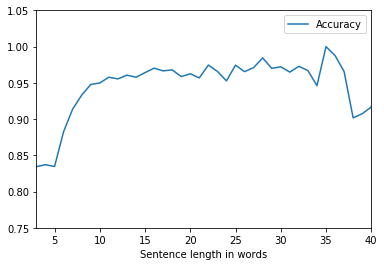

In [59]:
import matplotlib.pyplot as plt

plt.plot(range(3,61), [results[i][1] for i in range(len(results)) if len], label='Accuracy')
plt.xlim(3,40)
plt.ylim(0.75,1.05)
# plt.plot(l_er, label='Loss')
plt.xlabel('Sentence length in words')
plt.legend()
plt.show()

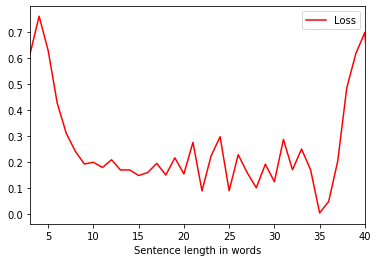

In [43]:
plt.plot(range(3,61),[results[i][0] for i in range(len(results)) if len], label='Loss', c='red')
plt.xlim(3,40)
# plt.ylim(0.75,1.05)
plt.xlabel('Sentence length in words')
plt.legend()
plt.show()

### Short sentences check
Testing whether the lower accuracy on shorter sentences is casued by wrong labeling - artificial interruption can create a sentence that makes sense as ended, even though it is split. Example:<br>
<b>Original</b>: I would like to buy a new car with five seats and an electric engine.<br>
<b>Artificially interrupted</b>: I would like to buy a new car

In [44]:
cnt = []
label = []
text = []

for index, row in pd_tm.iterrows():
    if len(row.text) > 0:
        cnt.append(len(row.text.split()))
        label.append(row.label)
        text.append(row.text)

In [45]:
d1 = {'text': text, 'cnt': cnt, 'label': label}
df1 = pd.DataFrame(data=d1)

In [46]:
s = df1.cnt.sort_values().index

In [47]:
df1 = df1.reindex(s)
df1 = df1.reset_index(drop=True)

In [48]:
df1

,text,cnt,label
0,akira,1,1
1,okay,1,0
2,okay,1,0
3,okay,1,0
4,hi,1,0
...,...,...,...
340057,give me one moment while i look this up let me...,103,1
340058,your first option is called restaurant la perl...,107,1
340059,you have several options close by the stadium ...,113,1
340060,sure let me see if i can find all that for you...,116,1


In [49]:
# make dataset

extract = []
NUM = 25

for i in range(5,16,1):
    extract.append(df1[(df1.cnt == i) & (df1.label == 1)].head(NUM))
    extract.append(df1[(df1.cnt == i) & (df1.label == 0)].head(NUM))
    
small_df = pd.concat(extract, axis=0).reset_index(drop=True)

In [50]:
small_df

,text,cnt,label
0,yeah that sounds about right,5,1
1,once they lost versus everton,5,1
2,awesome you are all set,5,1
3,they are playing okc energy,5,1
4,okay i can find that,5,1
...,...,...,...
545,the second is the pour house it has stars room...,15,0
546,okay that's great i wanted a morning flight an...,15,0
547,explain the cheapest is round trip lee's at pm...,15,0
548,i see that there is one time to leave on april...,15,0


In [51]:
tokenized_utterances = [tokenize_utterances(utterance) for utterance in small_df.text]

utterances_with_len = [[utterance, small_df.label[i], len(utterance)]
                 for i, utterance in enumerate(tokenized_utterances)]

fixed = []
for x in utterances_with_len: fixed.append(x)

utterances_with_len = fixed

sorted_utterances_labels = [(utterance_lab[0], utterance_lab[1]) for utterance_lab in utterances_with_len]

processed_dataset =\
    tf.data.Dataset.from_generator(lambda: sorted_utterances_labels, output_types=(tf.int32, tf.int32))

batched_dataset = processed_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))

In [52]:
pred = text_model.predict(batched_dataset)

In [53]:
text_model.evaluate(batched_dataset)

     35/Unknown - 0s 6ms/step - loss: 0.2869 - accuracy: 0.9309

[0.28692352617090366, 0.9309091]

In [54]:
pred_ = [i[0] for i in pred]

In [55]:
pred_ = [np.around(i,5) for i in pred_]

In [56]:
d2 = {'text': small_df.text, 'label': small_df.label, 'predicted': pred_}
df2 = pd.DataFrame(data=d2)

<b>False negatives</b>

In [57]:
df2[(df2.label == 1) & (df2.predicted <= 0.5)]

,text,label,predicted
4,okay i can find that,1,0.10057
56,can you help me find one,1,0.24071


<b>False positives</b>

In [58]:
df2[(df2.label == 0) & (df2.predicted >= 0.5)]

,text,label,predicted
31,no i do not need,0,0.99873
48,there have not been any,0,0.98869
85,if it's close to the beach,0,0.68357
90,i'd like to go after pm,0,0.99968
97,i'd like to pieces of soda,0,0.78416
127,how long is the drive from fairfield,0,0.95486
128,okay interesting the last question is are,0,0.51039
129,sure can you give me the name,0,0.93705
133,okay assistant thank you so much for,0,0.99364
146,awesome i'd like to hear one more,0,0.50586
